In [2]:
import numpy as np
import scipy
from scipy.cluster import hierarchy as hc
import pandas as pd
from skimage import morphology
from scipy import misc
from matplotlib import pyplot as plt
import math, time
from skimage import measure
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

from joblib import Parallel, delayed
import multiprocessing

import time

import warnings
warnings.filterwarnings('ignore')


In [3]:
%matplotlib inline  

In [4]:
## Set user-defined variables
roll_width = 20
sDir = '/Users/birdbrain/Documents/Research/Projects/Schatz/Data/g21chaotic/r4000_2015_09_16_fast/g21flow'
sBmp = 'bmps/%06d.bmp'
sFeatureVectors = 'feature_vectors/%06d.txt'
sSubPD = 'pd_sub/%06d.csv'
sSupPD = 'pd_sup/%06d.csv'

delta = 10

## Utility Functions

In [5]:
def loadData(_idx):
    
    # Get feature vectors
    _fv = pd.read_csv(sDir + "/" + (sFeatureVectors % idx), sep=' ', header=None)
    _fv = np.asarray(_fv.astype(np.int16))
    
    # Extract toplogical defects (a.k.a. singular points) from feature vectors
    offset = 5
    _td_p1 = _fv[(_fv[:,4+offset]==1),:]
    _td_p1 = np.hstack((_td_p1[:,[3,4]], np.ones((_td_p1.shape[0],1))))
    _td_m1 = _fv[(_fv[:,5+offset]==1),:]
    _td_m1 = np.hstack((_td_m1[:,[3,4]], np.ones((_td_m1.shape[0],1))*-1))
    _sp = pd.DataFrame(np.vstack((_td_p1, _td_m1)), columns=['x', 'y', 'type'])
    _sp = _sp.drop_duplicates()
    
    # Extract persistent homology pinch-off points from feature vectors
    _pinch = np.vstack((_fv[(_fv[:,0+offset]==1),:], _fv[(_fv[:,2+offset]==1),:]))
    _pinch = _pinch[:,[3,4]]
    _pinch = pd.DataFrame(_pinch, columns=['center_x', 'center_y'])
    _pinch = _pinch.drop_duplicates()
    
    # Get bitmap image
    _bmp = misc.imread(sDir + "/" + sBmp % idx)
    
    # Get H1 generators for spiral/target disambiguation
    _ph_features_sub = pd.read_csv(sDir + "/" + (sSubPD % idx))
    _ph_features_sub = pd.DataFrame(_ph_features_sub)
    
    _ph_dim1_sub = _ph_features_sub.loc[(_ph_features_sub['dim']==1) & ((_ph_features_sub['death'] - _ph_features_sub['birth']) >= delta) & (_ph_features_sub['birth']<=127)][['d_x','d_y']]
    
    _ph_features_sup = pd.read_csv(sDir + "/" + (sSupPD % idx))
    _ph_features_sup = pd.DataFrame(_ph_features_sup)
    
    _ph_dim1_sup = _ph_features_sup.loc[(_ph_features_sup['dim']==1) & ((_ph_features_sup['birth'] - _ph_features_sup['death']) >= delta) & (_ph_features_sup['birth']>=127)][['b_x','b_y']]
    
    _h1gens = np.vstack((_ph_dim1_sub, _ph_dim1_sup))
    _h1gens = pd.DataFrame(_h1gens, columns=['center_x', 'center_y'])
    
    return (_fv, _sp, _pinch, _bmp, _h1gens)


In [6]:
def Plot(list_of_things_to_plot):
    plt.rcParams['figure.figsize'] = (20.0, 10.0)
    for i,x in enumerate(list_of_things_to_plot):
        plt.subplot(1,len(list_of_things_to_plot),i+1,aspect='equal'); plt.pcolor(x); plt.colorbar(); plt.gca().invert_yaxis()
    

## The Code.

In [7]:
def add_defect(_input):
    defect_region = _input[0]
    id = _input[1]
    name = _input[2]
    shortname = _input[3]
    isstable = _input[4]
    attribute = _input[5]
    
    mask[defect_region] = id
    maskids[id] = name
    # Get centroid from the defect region
    row_sum = np.sum(defect_region,axis=0)
    col_sum = np.sum(defect_region,axis=1)
    row_nz = np.where(row_sum>0)
    col_nz = np.where(col_sum>0)
    row_center = float(row_nz[0][0] + row_nz[0][-1])/2.
    col_center = float(col_nz[0][0] + col_nz[0][-1])/2.
    image_defects.append([id, shortname, isstable, attribute, defect_region, [row_center, col_center]])
    

# GLOBAL VARIABLES USED
# singular_points
# sp

def classify_defect(defect, isstable):
    
    output_defects = []
    
    # Intersect defect with singular points
    defect_points = defect*sp

    # Convert to list of singular_point locations inside of defect region
    defect_list = (defect_points).nonzero()
    
    defect_list = np.column_stack((defect_list[0], defect_list[1]))
    defect_list = pd.DataFrame(defect_list,columns=['x','y'])
    defect_list = pd.merge(defect_list, singular_points, on=['x', 'y'])
    
    no_sps = defect_list.shape[0]
    
    if no_sps == 1:
        
        # Singleton (-1) = disclination (branch type)
        # Compute upper or lower disclination
        if defect_list['type'][0]==-1:
            output_defects.append([defect, 4, 'Disclination (concave)', 'D-', isstable, 'center=(%d,%d)' % (defect_list['x'][0],defect_list['y'][0])])

        # Singleton (+1) = disclination (lobe type)
        # Compute upper or lower disclination
        if defect_list['type'][0]==1:
            output_defects.append([defect, 7, 'Disclination (convex)', 'D+' , isstable, 'center=(%d,%d)' % (defect_list['x'][0],defect_list['y'][0])])
            
    if no_sps == 2:
        
        avg_x = np.average(defect_list['x'])
        avg_y = np.average(defect_list['y'])

        # Pair of (1, -1) = dislocation
        # Compute upper or lower disclination
        if len(defect_list.loc[defect_list['type']==1]) == 1:
            output_defects.append([defect, 10, 'Dislocation pair', 'DP' , isstable, 'center=(%d,%d)' % (avg_x,avg_y)])

        # Pair of (1, 1) = spiral or possibly a target
        # Compute the center and width (can be used to estimate the number of arms)
        if len(defect_list.loc[defect_list['type']==1]) == 2:

            # Get distance from center (average) to closest singular point
            # This is the width of the spiral.
            # Color area the size of this circular region as the spiral color.

            other_sps = pd.concat([singular_points, defect_list]).drop_duplicates(keep=False)
            other_sps = other_sps.append({'x':avg_x, 'y':avg_y, 'type':0}, ignore_index=True)

            dm = scipy.spatial.distance.pdist(other_sps.as_matrix(columns=['x','y']))
            dm = scipy.spatial.distance.squareform(dm)

            neighbors = dm[-1,:]
            neighbors = neighbors[neighbors>0]

            spiral = np.zeros(bmp.shape)
            spiral[avg_x, avg_y] = 1
            spiral = morphology.binary_dilation(spiral, morphology.disk(min(neighbors)))

            # Use H1 sublevel (existence of plume) to disambiguate spirals
            # If any plume exists inside the center of the spiral, turn it into a target

            small_spiral = morphology.binary_erosion(spiral, morphology.disk(min(neighbors)/2))
            target = np.multiply(small_spiral, plumes)
            
            if sum(sum(target)) > 0:
                output_defects.append([spiral, 12, 'Target', 'T', isstable, 'center=(%d,%d), radius=%0.2f' % (avg_x,avg_y,min(neighbors))])
            else:
                output_defects.append([spiral, 14, 'Spiral', 'S', isstable, 'center=(%d,%d), radius=%0.2f' % (avg_x,avg_y,min(neighbors))])

    if no_sps >= 3:
        
        # Do a SVD to see line of best fit and how well the configuration fits into a line.
        # If it does, the it's potentially a grain boundary of length > 1

        data = np.column_stack(((defect_points).nonzero()[0], (defect_points).nonzero()[1]))
        datamean = data.mean(axis=0)
        uu, dd, vv = np.linalg.svd(data - datamean)
        # vv[0] is the direction vector of the line of best fit. Need to get dot products of
        # original points with this vector vv[0] to put them in order along the line
        ordering = np.dot((data - datamean),np.reshape(vv[0],(2,1)))
        
        # Append the ordering values to the dataframe
        defect_list['order'] = ordering
        defect_list = defect_list.sort(['order'])
        # Check that the ordering along the principal component is alternating with respect to the singular point type
        isAlternating = (sum(abs(defect_list['type'][0:len(defect_list)-1].as_matrix() + defect_list['type'][1:len(defect_list)].as_matrix())) == 0)
        # Check that the points aren't too close to linear
        isLinear = (dd[1] < (1./5.)*roll_width)
        isDispersed = (dd[1] > (3./4.)*roll_width)
        if (isAlternating & ~isLinear & ~isDispersed):
            output_defects.append([defect, 11, 'Grain boundary', 'GB', isstable, 'chain_length=%d' % (no_sps)])
        elif (len(defect_list.loc[defect_list['type']==1]) == 2):
            # Check to see if it is a target. Presence of two +1 defects that don't have any -1 in between them
            target_points = defect_list.loc[defect_list['type']==1]
            avg_x = np.average(target_points['x'])
            avg_y = np.average(target_points['y'])
            defect_list['distance'] = defect_list.apply(lambda d: np.linalg.norm(np.asarray([d['x'],d['y']])-np.asarray([avg_x,avg_y])), axis=1)
            center_points = defect_list.loc[defect_list['type']==1]
            outside_points = defect_list.loc[defect_list['type']==-1]
            min_center = min(center_points['distance'])
            min_outside = min(outside_points['distance'])
            if (min_outside > max(1.25*min_center, roll_width)):
                for i in outside_points.index:
                    disclination = np.zeros(bmp.shape)
                    o_x = int(outside_points.ix[i]['x'])
                    o_y = int(outside_points.ix[i]['y'])
                    disclination[o_x,o_y] = 1
                    disclination = morphology.binary_dilation(disclination, morphology.disk(0.5*roll_width))
                    output_defects.append([disclination, 4, 'Disclination (concave)', 'D-', isstable, 'center=(%d,%d)' % (o_x,o_y)])
                
                target = np.zeros(bmp.shape)
                target[avg_x, avg_y] = 1
                target = morphology.binary_dilation(target, morphology.disk(min_outside))
                
                target_defects = np.multiply(target, plumes)

                if sum(sum(target_defects)) > 0:
                    output_defects.append([target, 12, 'Target' ,'T', isstable, 'center=(%d,%d), radius=%0.2f' % (avg_x,avg_y,min_outside)])
                else:
                    output_defects.append([target, 14, 'Spiral','S' , isstable, 'center=(%d,%d), radius=%0.2f' % (avg_x,avg_y,min_outside)])
                
    return output_defects


In [8]:
idx_range = range(1,3501)

# idx_range = range(900,950)

all_counts = np.zeros((len(idx_range),18))

# heat_maps = [[np.zeros((421,421))]*8 for i in range(len(idx_range))]
# defect_indices = np.asarray([0,1,4,7,10,11,12,14])

num_cores = multiprocessing.cpu_count()

# ims = []

# plt.rcParams['figure.figsize'] = (10.0, 10.0) 
# plt.set_cmap('gray')

# fig = plt.figure();
# ax = fig.add_subplot(111);
# fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None);

# Crop the temperature field to a circle first.
c = np.zeros((421,421))
centerx = 210
centery = 210
radius=195

for i in range(c.shape[0]):
    for j in range(c.shape[1]):
        if ((i-centerx)**2 + (j-centery)**2 < radius**2):
            c[i,j] = 1
            
c = c.astype(np.int)

total_region_area = float(np.count_nonzero(c))

maskids = {0:'Unassigned'} # Definitions of mask types
maskids[14]='Spiral'

for idx in idx_range:
    
    if idx % 50 == 0:
        print idx
    
#     start = time.time()

    (features, singular_points, pinches, bmp, plumes_loc) = loadData(idx)

#     end = time.time()
#     print("Loaded features: ", end - start)
#     start = end

    ## Create mask/classification image
    mask = np.zeros(bmp.shape) # Location of masks


    ## GET PARALLEL ROLL REGIONS
    # Dilate the absolute value of the singular_points by 1 roll_width
    # Mask out the original image by this dilation
    # Remaining regions are the parallel roll regions

    singular_points = singular_points.astype(np.int)
    sp = np.zeros(bmp.shape)
    sp[singular_points['x'], singular_points['y']] = 1

    sp_dilated = morphology.binary_dilation(sp, morphology.disk(roll_width))

    # Remove small regions not filtered out
    sp_dilated = morphology.binary_dilation(sp_dilated, morphology.disk(0.5*roll_width))
    sp_dilated = morphology.binary_erosion(sp_dilated, morphology.disk(0.5*roll_width))

    # Invert to ge the indicator function for the parallel roll regions
    sp_dilated_mask = np.invert(sp_dilated)

    # Add these regions to the mask
    mask[sp_dilated_mask] = 1
    maskids[1] = 'Parallel rolls'
    

    ## GET ROLL INSTABILITIES
    # Find pinch persistence pinches within parallel roll regions

#     pinches = pinches.astype(np.int)

#     p = np.zeros(bmp.shape)
#     p[pinches['center_x'], pinches['center_y']] = 1

#     p = np.multiply(sp_dilated_mask, p)
#     p = morphology.binary_dilation(p, morphology.disk(0.25*roll_width))
#     p = np.multiply(sp_dilated_mask, p)

#     # Add these regions to the mask
#     mask[p] = 2
#     maskids[2] = 'Roll instabilities'


    ## IDENTIFY DEFECTS 
    # Make the master list of defects
    image_defects = []

#     # Get list of pinches to use for filtering
    p = np.zeros(bmp.shape)
#     p[pinches['center_x'], pinches['center_y']] = 1
#     p = morphology.binary_dilation(p, morphology.disk(0.25*roll_width))

    # Get list of persistence generators to use for differentiating spirals/targets
    plumes_loc = plumes_loc.astype(np.int)
    plumes = np.zeros(bmp.shape)
    plumes[plumes_loc['center_x'], plumes_loc['center_y']] = 1

    # Cluster the singular points
    stable_sp = morphology.binary_dilation(sp, morphology.disk(0.5*roll_width))
    stable_components = measure.label(stable_sp, background=0)+1

    # Find clusters that don't intersect with the dilated pinch-off points by isolating and removing those that do
    remove_components = np.multiply(stable_components, p)

    component_list = np.unique(stable_components)
    components_unstable = np.unique(remove_components)
    components_stable = list(set(component_list) - set(components_unstable))

    plotlist = []
    

    # STABLE DEFECTS (absense of persistence pinch-off features)   
    results = Parallel(n_jobs=num_cores)(delayed(classify_defect)(stable_components == component, 1) for component in components_stable)
    for process_defects in results:
        for new_defect in process_defects:
            add_defect(new_defect)

    # UNSTABLE DEFECTS (presence of persistence pinch-off features)
    results = Parallel(n_jobs=num_cores)(delayed(classify_defect)(components_unstable == component, 0) for component in components_unstable)
    for process_defects in results:
        for new_defect in process_defects:
            add_defect(new_defect)
            
    # Compute singular points in unknown regions
    unknown = (mask == 0).astype(int)
    unknown_sp = np.multiply(unknown, morphology.binary_dilation(sp,morphology.disk(1)))

    # Shrink the unknown region
    unknown = (mask == 0).astype(int)
    unknown_shrunk = np.multiply(unknown, morphology.binary_dilation(sp,morphology.disk(roll_width)))
    unknown_shrunk = morphology.binary_erosion(unknown, morphology.disk(0.5*roll_width))
    unknown_shrunk = morphology.binary_dilation(unknown_shrunk, morphology.disk(0.5*roll_width))
    not_unknown = (mask>1).astype(int)
    mask[np.invert((not_unknown ^ unknown_shrunk).astype(bool))] = 1


    # # Overlay instabilities
    # mask[p] = 2;
    # maskids[2] = 'Roll instabilities'

#     # Overlay singular points in unknown regions
#     mask[unknown_sp] = 9;
#     maskids[9] = 'Unmarked singular points'

    all_defects = [x[0] for x in image_defects]
    count_defects = [all_defects.count(i) for i in range(0,15)]
    all_counts[idx - idx_range[0],0:15] = count_defects
    
    # Get the areas of the classified/unclassified/domain regions
    all_counts[idx - idx_range[0],15] = float(sum(mask[c==1]==0.))/total_region_area # Unassigned
    all_counts[idx - idx_range[0],16] = float(sum(mask[c==1]==1.))/total_region_area # Domain
    all_counts[idx - idx_range[0],17] = float(sum(mask[c==1]>1.))/total_region_area # Assigned defects

    
    
    
#     # Plot the labeled defect regions on top of the temperature field
#     print_mask = mask.T
#     print_bmp = bmp
#     print_bmp[c==0] = 0
#     print_bmp[print_mask==1.] = 0.5*print_bmp[print_mask==1.]
    
#     txt_out = []
#     for defect in image_defects:
#         outline = defect[4].T ^ morphology.binary_dilation(defect[4].T,morphology.disk(2))
#         print_bmp[outline==1] = 255
#         txt = ax.annotate(defect[1],(defect[5][1]-5,defect[5][0]), color='white', fontweight='bold', fontsize=10)
#         txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])
#         txt_out.append(txt)
#     print_bmp[np.multiply(unknown, morphology.binary_dilation(sp,morphology.disk(2))).T==1] = 0
#     print_bmp[unknown_sp.T==1] = 255
    
#     frame = ax.imshow(print_bmp)
        
#     txt_title = ax.annotate("Frame %d" % idx, (10,15), color='white', fontsize=18)
#     ax.axis('off')
#     ims.append([frame, txt_title] + txt_out)


#     # Generate heat maps of each defect type
#     heat_maps[idx - idx_range[0]][0] = (mask==0).astype(int)
#     heat_maps[idx - idx_range[0]][1] = (mask==1).astype(int)
    
#     for defect in image_defects:
#         defect_idx = np.where(defect_indices==defect[0])[0][0]
#         heat_maps[idx - idx_range[0]][defect_idx] = heat_maps[idx - idx_range[0]][defect_idx] + defect[4]
        
    

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500


In [ ]:
total_heat_maps = [[np.zeros((421,421))]*8 for i in range(5)]

for k in range(5):
    for i in range(100):
        for j in range(2,8):
            total_heat_maps[k][j] = total_heat_maps[k][j] + heat_maps[i+k*100][j]

plt.set_cmap('hot')
plt.rcParams['figure.figsize'] = (35.0, 35.0)
f = plt.figure(facecolor='white')

for k in range(5):
    for j in range(2,8):

        plt.subplot(5,6,(j-1)+k*6)
        ax = plt.gca()
        im = ax.imshow(total_heat_maps[k][j].T)
#         ax.axis('off')
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        plt.title(maskids[defect_indices[j]], fontsize=20)
        if j==2:
            plt.ylabel('Frames %d to %d' % (k*100+1, (k+1)*100), fontsize=20)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        ax2 = plt.colorbar(im, cax=cax)
        ax2.ax.tick_params(labelsize=20)
        
plt.show();
    

In [ ]:
writer = animation.FFMpegWriter(bitrate=500, fps=10)
anim = animation.ArtistAnimation(fig, ims, blit=True, repeat_delay=350)
anim.save(sDir + '/defect_animation_1_999.mp4', writer=writer)

[[ 0.          0.          0.         ...,  0.23454526  0.635954
   0.12950074]
 [ 0.          0.          0.         ...,  0.251807    0.62390177
   0.12429123]
 [ 0.          0.          0.         ...,  0.28448788  0.59657278
   0.11893934]
 ..., 
 [ 0.          0.          0.         ...,  0.20286104  0.64878515
   0.14835381]
 [ 0.          0.          0.         ...,  0.25065956  0.6325117
   0.11682873]
 [ 0.          0.          0.         ...,  0.23624547  0.58165616
   0.18209838]]


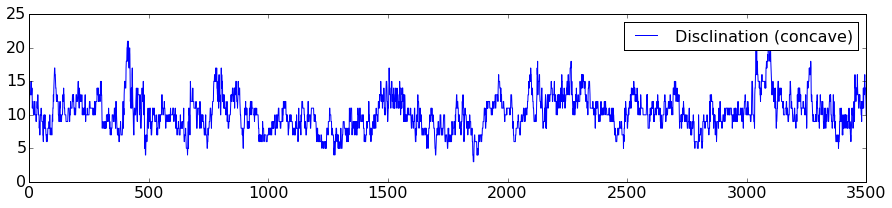

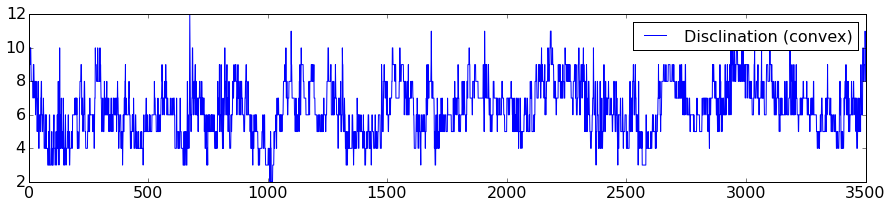

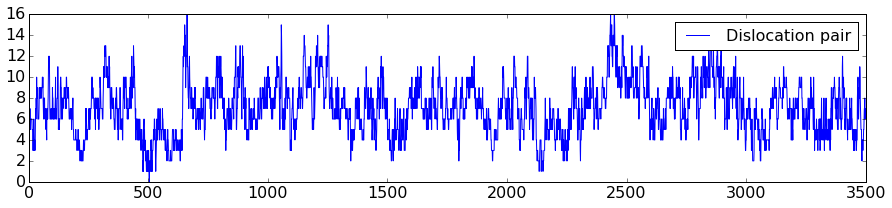

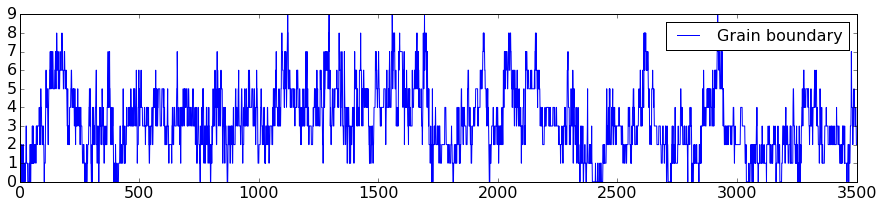

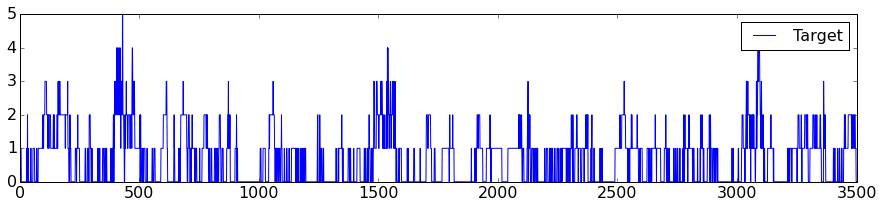

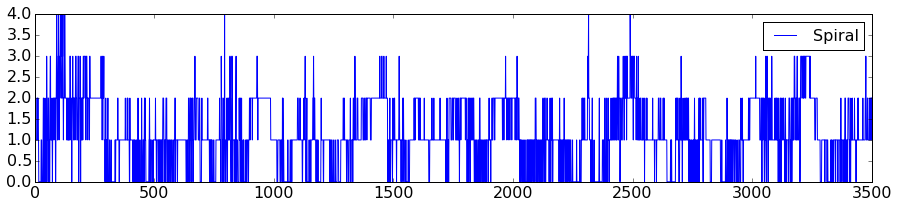

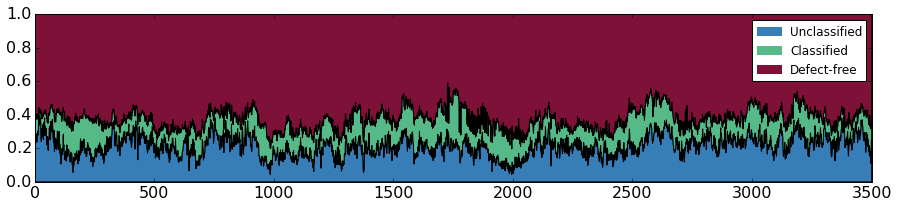

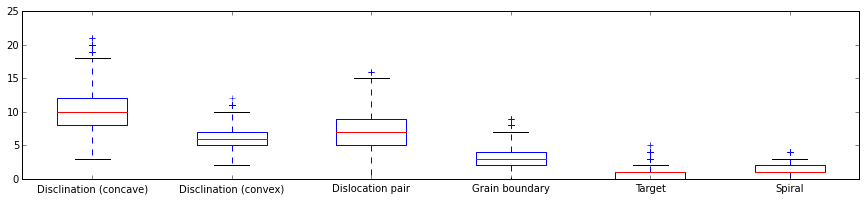

In [9]:
print all_counts


plt.rcParams['figure.figsize'] = (15.0, 3.0)

for i in [4,7,10,11,12,14]:
    plt.plot(idx_range, all_counts[:,i], label=maskids[i]);
    ax = plt.gca()
    plt.legend(fontsize=16);
    plt.setp(ax.get_xticklabels(), fontsize=16)
    plt.setp(ax.get_yticklabels(), fontsize=16)
    plt.show();

    
unclassified = all_counts[:,15]
domain = all_counts[:,16]
classified = all_counts[:,17]

plt.stackplot(idx_range,
          unclassified, classified, domain, 
          colors=['#377EB8','#55BA87','#7E1137'])
ax = plt.gca()
plt.legend(fontsize=16);
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)

# creating the legend manually
plt.legend([mpatches.Patch(color='#377EB8'),  
            mpatches.Patch(color='#55BA87'), 
            mpatches.Patch(color='#7E1137')], 
           ['Unclassified','Classified','Defect-free'])
plt.show()


plt.boxplot(all_counts[:,[4,7,10,11,12,14]], labels=[maskids[i] for i in [4,7,10,11,12,14]])
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
plt.show()

In [10]:
np.savetxt(sDir + "/simple_defect_stats/all_counts.txt", all_counts, fmt='%d', delimiter=' ')

In [ ]:
mask[c==1]

In [ ]:
print maskids
Plot([bmp.T, mask])

In [ ]:
image_defects



In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(singular_points[['x','y']], 'single')

In [ ]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('singular point')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=360.,
    leaf_font_size=13.,  # font size for the x axis labels
    color_threshold=20, # One wavelength
    labels=np.asarray(singular_points['type']),
)
plt.show()